In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.datasets import mnist
from keras.applications import Xception
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
import os


In [ ]:
# Load the Data
# Specify the path to the data folder
data_folder = '/content/drive/MyDrive/chest_xray'

# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values between 0 and 1

# Load the training data
train_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'train'),  # Path to the training data folder
    target_size=(224, 224),  # Resize the images to a suitable size
    batch_size=32,
    class_mode='binary',  # Pneumonia and non-pneumonia
    shuffle=True # Reduce the risk of order bias during training
)

# Load the validation data
val_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'val'),  # Path to the validation data folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load the testing data
test_data = data_generator.flow_from_directory(
    os.path.join(data_folder, 'test'),  # Path to the testing data folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 7787 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 633 images belonging to 2 classes.


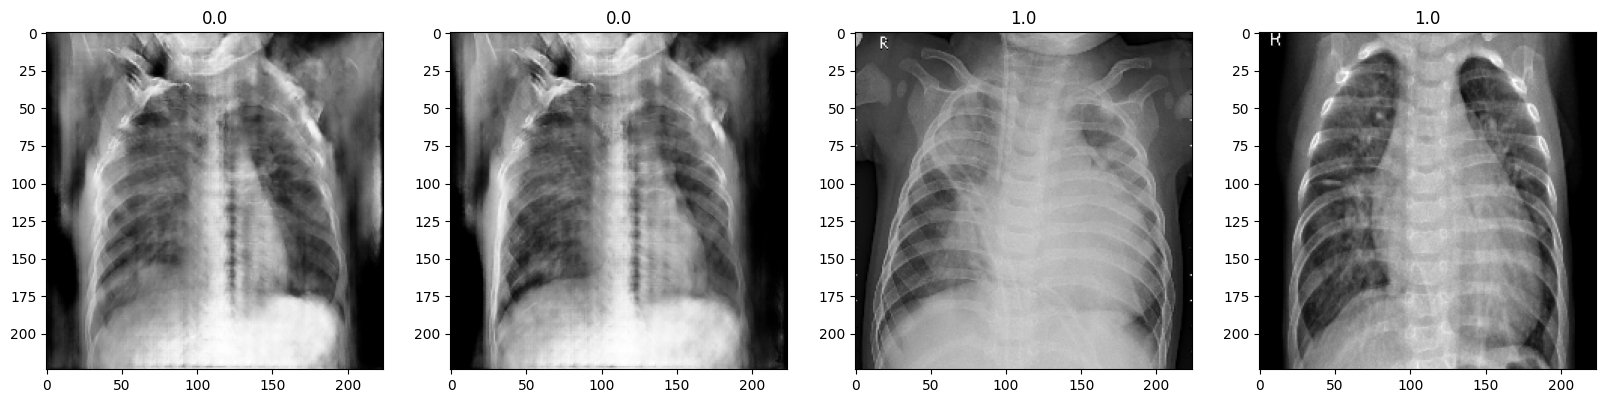

In [ ]:
# Retrieve a batch of data from the train_data generator
batch = next(train_data)

# Visualise the first four images from a batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

plt.show()


Looking at the images above, 0 represents normal and 1 represents pneumonia. So the batch contains both normal and pneumonia images. This is a good thing! It means that the shuffling during loading worked. Now, I want to visualise more images looking at 5 normal X-rays and 5 pneumonia X-rays to compare.

## CNN Modeling
***

In [ ]:
def run_model(model):
    """
    run_model will take in a built model and compile and fit to the training data. It will return training history.
    """
    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping and class weights
    history = model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[early_stopping])
    return history


In [ ]:
#Create Function for evaluation of model, confusion matrix, and classification report

def evaluation(model, history):
    '''
    Function takes in a model and outputs a
    confusion matrix and classification report
    '''
    # Display a summary of the model's structure
    print(model.summary())

    # Plot training and validation loss to visualize model performance
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy to visualize model performance
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate the model's performance on the test data
    test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)


    # Get the predicted probabilities for the test data
    predictions = model.predict(test_data).flatten()

    # Convert probabilities to binary predictions (0 or 1)
    binary_predictions = np.round(predictions)

    # Get the true labels of the test data
    true_labels = test_data.labels

    # Generate the classification report to show precision, recall, F1-score, and support for each class
    report = classification_report(true_labels, binary_predictions)
    print(report)

    # Micro-averaged recall (overall recall)
    micro_recall = recall_score(true_labels, binary_predictions, average='micro')
    print('Overall recall', micro_recall)

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, binary_predictions)

    # Plot the confusion matrix
    labels = ['Healthy', 'Pneumonia']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute the Area Under the ROC Curve (AUC/ROC) to assess model discrimination

    # Get the model's predicted probabilities for the test and validation data
    test_predictions = model.predict(test_data).ravel()
    val_predictions = model.predict(val_data).ravel()

    # Get the true labels of the test and validation data
    test_labels = test_data.labels
    val_labels = val_data.labels

    # Compute the AUC for the test and validation data
    test_auc = roc_auc_score(test_labels, test_predictions)
    val_auc = roc_auc_score(val_labels, val_predictions)

    # Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for the ROC curve
    test_fpr, test_tpr, _ = roc_curve(test_labels, test_predictions)
    val_fpr, val_tpr, _ = roc_curve(val_labels, val_predictions)

    # Plot the ROC curve for test and validation data to visualize model performance
    plt.figure(figsize=(8, 6))
    plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_auc))
    plt.plot(val_fpr, val_tpr, label='Validation ROC Curve (AUC = {:.2f})'.format(val_auc))

    # Plot the diagonal line representing a random classifier (no discrimination)
    plt.plot([0, 1], [0, 1], 'k--')

    # Set plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


### MODEL 1
We will start by creating a baseline CNN model.

In [ ]:
# Build a baseline CNN model
CNN_baseline = Sequential()

# Conv2D layer to extract relevant features from the input images
CNN_baseline.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))

# MaxPooling layer to downsample the feature maps
CNN_baseline.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to transform from 2D to 1D for the Dense layer to take as an input
CNN_baseline.add(Flatten())

# Dense layer to perform high-level reasoning and classification
CNN_baseline.add(Dense(128, activation='relu'))

# Output layer with activation sigmoid for binary classification
CNN_baseline.add(Dense(1, activation='sigmoid'))

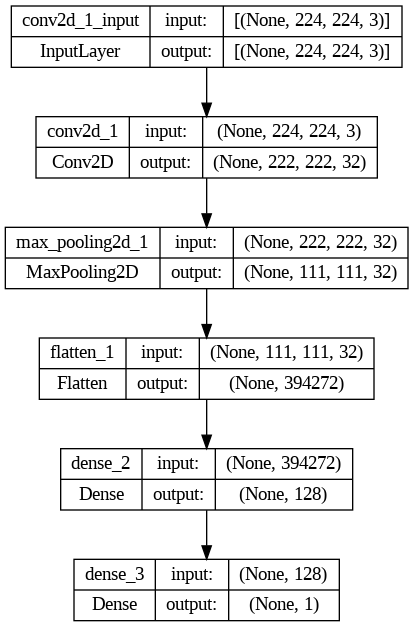

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture and save it as PNG
plot_model(CNN_baseline, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved PNG image
from IPython.display import Image
Image(filename='model_architecture.png')

In [ ]:
# Train the CNN model and get the history object
CNN_history = run_model(CNN_baseline)

Epoch 1/5
244/244 [==============================] - 603s 2s/step - loss: 0.5675 - accuracy: 0.9286 - val_loss: 0.0387 - val_accuracy: 0.9899
Epoch 2/5
244/244 [==============================] - 610s 2s/step - loss: 0.0367 - accuracy: 0.9868 - val_loss: 0.0271 - val_accuracy: 0.9899
Epoch 3/5
244/244 [==============================] - 624s 3s/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 4/5
244/244 [==============================] - 620s 3s/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0116 - val_accuracy: 0.9899
Epoch 5/5
244/244 [==============================] - 619s 3s/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 7.2139e-04 - val_accuracy: 1.0000


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 394272)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               50466944  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50467969 (192.52 MB)
Trainable params: 50467969 (192.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________

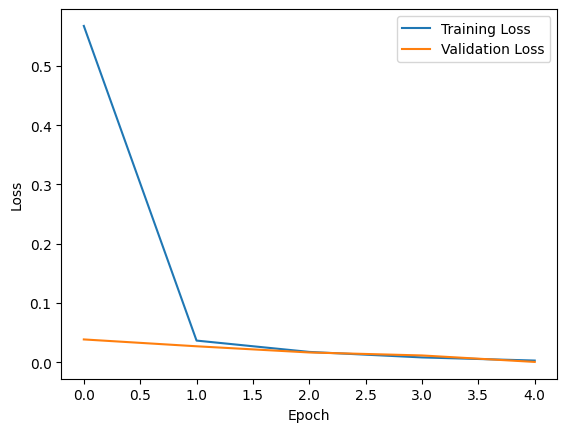

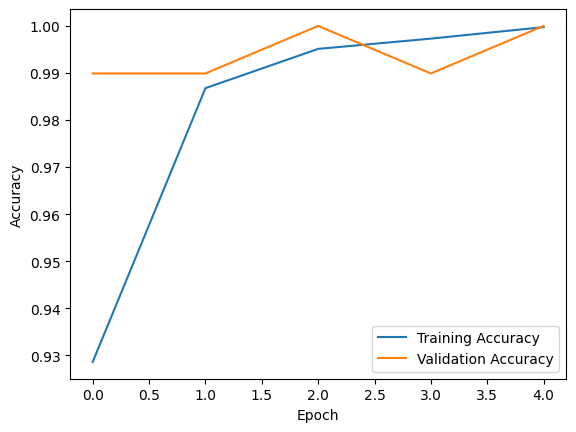

20/20 [==============================] - 120s 6s/step - loss: 1.4959 - accuracy: 0.7520
Test Loss: 1.4958902597427368
Test Accuracy: 0.7519747018814087
20/20 [==============================] - 17s 815ms/step
              precision    recall  f1-score   support

           0       0.99      0.36      0.53       243
           1       0.71      1.00      0.83       390

    accuracy                           0.75       633
   macro avg       0.85      0.68      0.68       633
weighted avg       0.82      0.75      0.71       633

Overall recall 0.7519747235387045


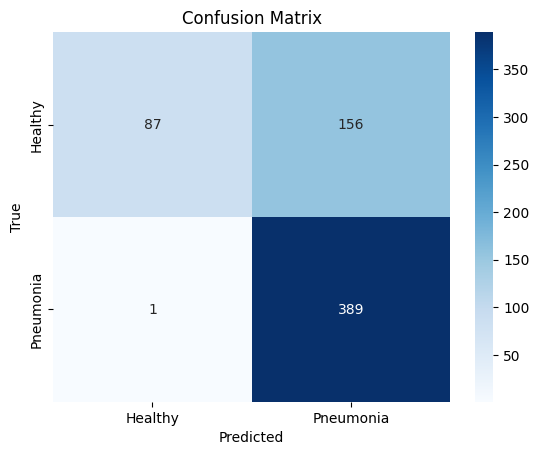

4/4 [==============================] - 2s 396ms/step


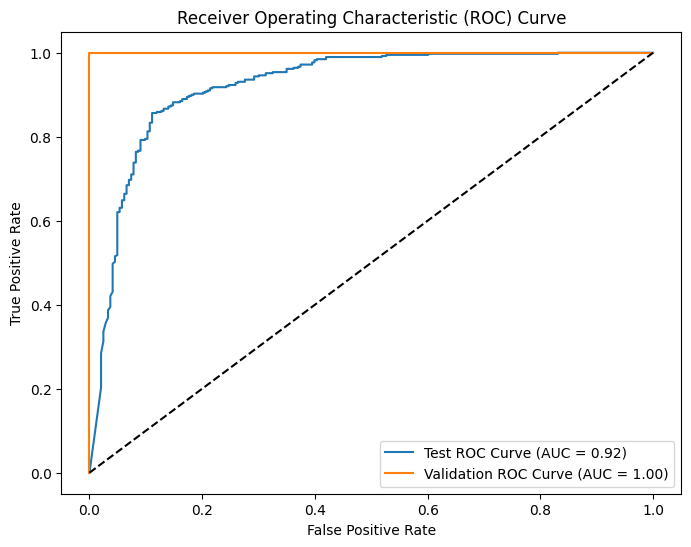

In [ ]:
# Evaluate the model using the history object
CNN_baseline_evaluation = evaluation(CNN_baseline, CNN_history)

I will go ahead and save the model so that it will not need to be re-trained in the future.

In [ ]:
# Save Model
CNN_baseline.save('/content/drive/MyDrive/models/CNN_baseline_.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### MODEL 2

Things to add to the baseline model to try and increase performance:
1. Three convolutional layers (instead of 1) with increasing filter sizes (32, 64, 128).
2. A dropout layer with a dropout rate of 0.5 to reduce overfitting.


In [ ]:
CNN_model_2 = Sequential(name='CNN_model_2')

# 1st Conv2D layer
CNN_model_2.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Conv2D layer
CNN_model_2.add(Conv2D(64, (3,3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Conv2D layer
CNN_model_2.add(Conv2D(128, (3,3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
CNN_model_2.add(Flatten())

# Dense layer
CNN_model_2.add(Dense(128, activation='relu'))
# Dropout layer to to reduce overfitting
CNN_model_2.add(Dropout(0.5))

# Output layer
CNN_model_2.add(Dense(1, activation='sigmoid'))

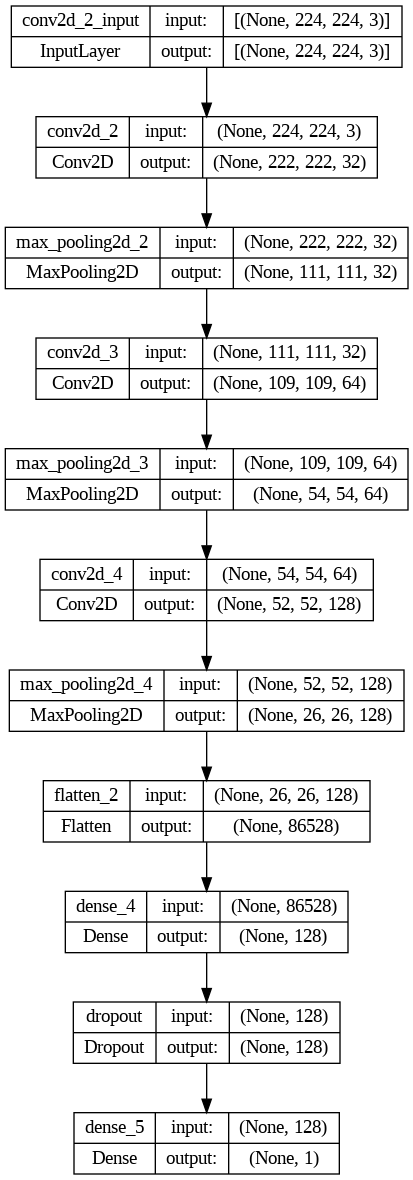

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture and save it as PNG
plot_model(CNN_model_2, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved PNG image
from IPython.display import Image
Image(filename='model_architecture.png')

In [ ]:
CNN_history = run_model(CNN_model_2)

Epoch 1/5
244/244 [==============================] - 1362s 6s/step - loss: 0.1586 - accuracy: 0.9367 - val_loss: 0.1066 - val_accuracy: 0.9697
Epoch 2/5
244/244 [==============================] - 1160s 5s/step - loss: 0.0797 - accuracy: 0.9732 - val_loss: 0.1067 - val_accuracy: 0.9394
Epoch 3/5
244/244 [==============================] - 1009s 4s/step - loss: 0.0697 - accuracy: 0.9756 - val_loss: 0.0727 - val_accuracy: 0.9798
Epoch 4/5
244/244 [==============================] - 958s 4s/step - loss: 0.0480 - accuracy: 0.9814 - val_loss: 0.0417 - val_accuracy: 0.9798
Epoch 5/5
244/244 [==============================] - 1042s 4s/step - loss: 0.0381 - accuracy: 0.9864 - val_loss: 0.0491 - val_accuracy: 0.9899


Model: "CNN_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 128)       

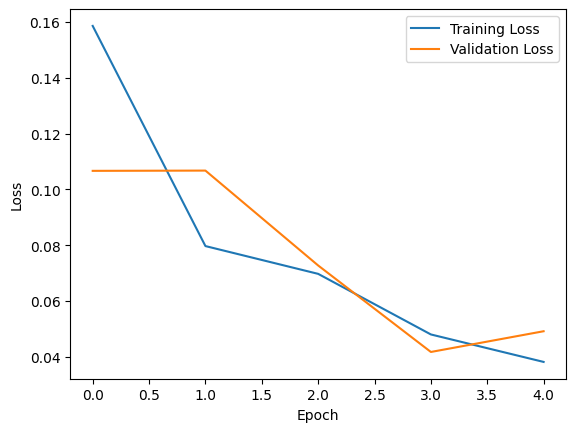

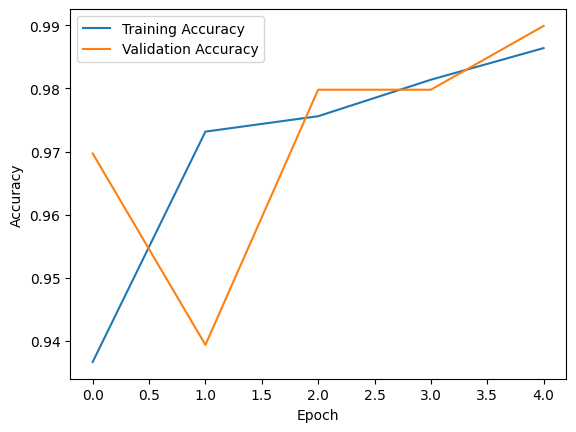

20/20 [==============================] - 28s 1s/step - loss: 1.0366 - accuracy: 0.7820
Test Loss: 1.0366480350494385
Test Accuracy: 0.7819905281066895
20/20 [==============================] - 28s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.46      0.62       243
           1       0.75      0.98      0.85       390

    accuracy                           0.78       633
   macro avg       0.84      0.72      0.73       633
weighted avg       0.82      0.78      0.76       633

Overall recall 0.7819905213270142


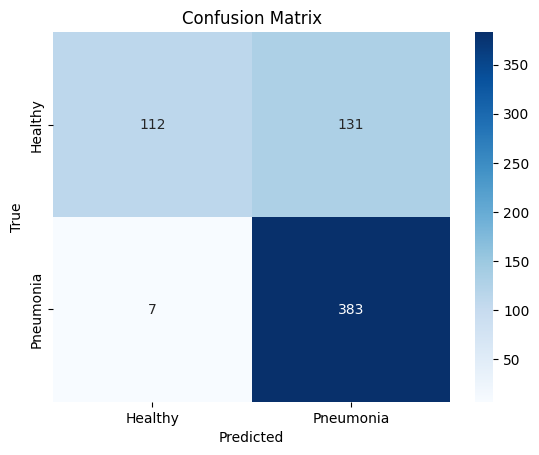

4/4 [==============================] - 4s 635ms/step


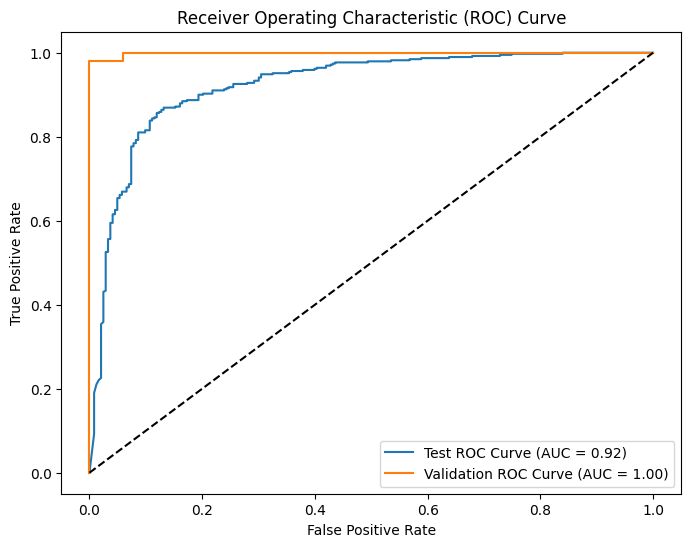

In [ ]:
evaluation(CNN_model_2, CNN_history)

In [ ]:
# Save Model
CNN_model_2.save('/content/drive/MyDrive/models/CNN_model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
